<a href="https://colab.research.google.com/github/AKMADOU/Zindi-Africa/blob/main/Airqo_StarterNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2><center> Welcome to the Faulty Air-Quality Sensor Challenge</h2></center>
<figure>
<center><img src ="https://drive.google.com/uc?export=view&id=1hSOAfRhJ_jo-MZAjq81VYJu5bZNL7EjD" width = "800" height = '500'/>

*About the problem*
> AirQo’s air quality sensing network has more than 120 low-cost devices deployed across Uganda; in most cases, these devices are deployed in unmonitored or perilous environments. These low-cost electronic devices are susceptible to breakdown caused by communication malfunction, aging, wear and tear, manufacturing deficiencies, incorrect calibration, mishandling and other external environmental factors. Faults lead to data inaccuracies and data loss, which impacts decisions and policies that could significantly impact people’s lives. 

*Objective of this challenge*
> In this challenge, your task is to develop a binary clasification model to identify faulty sensors, regardless of the device type. The model will be used by AirQo to automatically flag devices that have faulty readings. 

Device failure detection and monitoring is critical to AirQo’s work; faulty devices need to be identified, isolated and fixed or replaced with urgency



## Table of contents:

1. [Importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Missing values and duplicates](#Missing)
5. [Outliers](#Outliers)
6. [Feature engineering](#Engineering)
7. [Date features EDA](#Dates)
8. [Correlations - EDA](#Correlations)
9. [Preprocess test dataset](#Preprocess)
10. [Modelling](#Modelling)
11. [Making predictions of the test set and creating a submission file](#Predictions)
12. [TO DOs](#Tips)

<a name="Libraries"></a>
## 1. Importing libraries


In [94]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a name="Data"></a>
## 2. Loading data

In [95]:
# Load files
train = pd.read_csv('/content/train.csv', parse_dates = ['Datetime'])
test = pd.read_csv('/content/test.csv', parse_dates = ['Datetime'])
samplesubmission = pd.read_csv('/content/SampleSubmission.csv')

# Preview train dataset
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,24.90000,70.00000,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,20.90000,89.00000,0


In [96]:
#sensor difference
train['difference_sensor']=train['Sensor1_PM2.5']-train['Sensor2_PM2.5']
test['difference_sensor']=test['Sensor1_PM2.5']-test['Sensor2_PM2.5']

In [97]:
# Preview test dataset
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,difference_sensor
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75000,114.78000,22.20000,56.00000,-24.03000
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03000,52.18000,NaN,NaN,3.85000
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35000,346.73000,28.10000,63.00000,40.62000
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17000,83.85000,21.60000,82.00000,-20.68000
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23000,53.07000,22.70000,80.00000,16.16000


In [98]:
# Preview sample submission file
samplesubmission.head()

,ID,Offset_fault
0,ID_STL3V9B2OU12,0
1,ID_U2EKAY4SGA94,0
2,ID_UJFLEWQR0U4N,0
3,ID_S2C2GPGA4R5I,0
4,ID_5V2C2ZL221H8,0


In [99]:
train.isna().sum()


ID                      0
Datetime                0
Sensor1_PM2.5        3614
Sensor2_PM2.5        3614
Temperature          3549
Relative_Humidity    3549
Offset_fault            0
difference_sensor    3614
dtype: int64

In [100]:
test.isna().sum()

ID                       0
Datetime                 0
Sensor1_PM2.5            0
Sensor2_PM2.5            0
Temperature          88090
Relative_Humidity    88090
difference_sensor        0
dtype: int64

In [101]:
# train.fillna(value={'Sensor1_PM2.5':train['Sensor1_PM2.5'].mean()},inplace=True)
# train.fillna(value={'Sensor2_PM2.5':train['Sensor2_PM2.5'].mean()},inplace=True)
test.fillna(value={'Temperature':0},inplace=True)
test.fillna(value={'Relative_Humidity':0},inplace=True)
test.fillna(value={'difference_sensor':0},inplace=True)
test.isna().sum()

ID                   0
Datetime             0
Sensor1_PM2.5        0
Sensor2_PM2.5        0
Temperature          0
Relative_Humidity    0
difference_sensor    0
dtype: int64

In [102]:
test.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,difference_sensor
count,127361.00000,127361.00000,127361.00000,127361.00000,127361.00000
mean,42.79536,43.95843,7.30277,22.26732,-1.16307
std,27.83873,28.26034,11.13139,34.82821,11.80517
min,1.23000,0.78000,0.00000,0.00000,-128.56000
25%,24.67000,25.58000,0.00000,0.00000,-7.44000
50%,39.77000,39.88000,0.00000,0.00000,1.92000
75%,52.03000,52.83000,20.50000,53.00000,5.90000
max,927.78000,894.75000,34.00000,97.00000,150.00000


In [104]:
train.fillna(value={'Sensor1_PM2.5':0},inplace=True)
train.fillna(value={'Sensor2_PM2.5':0},inplace=True)
train.fillna(value={'Temperature':0},inplace=True)
train.fillna(value={'Relative_Humidity':0},inplace=True)
train.fillna(value={'difference_sensor':0},inplace=True)
train.isna().sum()

ID                   0
Datetime             0
Sensor1_PM2.5        0
Sensor2_PM2.5        0
Temperature          0
Relative_Humidity    0
Offset_fault         0
difference_sensor    0
dtype: int64

In [105]:
train.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,difference_sensor
count,297177.00000,297177.00000,297177.00000,297177.00000,297177.00000,297177.00000
mean,40.75120,38.18302,23.45489,78.03676,0.37107,2.53694
std,28.35220,28.47303,4.01619,15.71974,0.48309,8.11673
min,-9.45000,-9.70000,16.70000,27.00000,0.00000,-166.54000
25%,22.65000,19.70000,20.40000,67.00000,0.00000,-0.65000
50%,36.77000,34.02000,22.00000,83.00000,0.00000,2.90000
75%,49.22000,47.38000,26.60000,91.00000,1.00000,6.95000
max,997.96000,997.26000,34.90000,99.00000,1.00000,276.48000


In [106]:
def finding_outliers(train,variable_name):
    iqr=train[variable_name].quantile(0.75)-train[variable_name].quantile(0.25)
    lower=train[variable_name].quantile(0.25)-1.5*iqr
    upper= train[variable_name].quantile(0.75)+1.5*iqr
    return train[(train[variable_name]< lower)|(train[variable_name]>upper)]

In [107]:
finding_outliers(train,'Relative_Humidity').sort_values('Relative_Humidity')

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,difference_sensor
103,ID_UL9WZBMCZ441,2022-01-12 10:43:23,15.98000,9.38000,34.90000,27.00000,1,6.60000
194966,ID_M7HDRKP232EZ,2022-01-19 12:59:40,24.17000,18.57000,34.90000,27.00000,1,5.60000
194986,ID_UWFFBVWKG0MR,2022-01-19 14:21:50,21.45000,28.10000,34.90000,27.00000,0,-6.65000
195149,ID_U1OKWIHGKG6W,2022-01-12 17:04:32,16.02000,21.43000,34.90000,27.00000,0,-5.41000
195164,ID_TW4D6S1DUBIA,2021-12-23 11:16:18,10.77000,7.42000,34.90000,27.00000,1,3.35000
...,...,...,...,...,...,...,...,...
281909,ID_ZW1C88HXG8B0,2022-01-12 15:37:45,10.90000,7.80000,34.00000,30.00000,1,3.10000
158904,ID_PLA1C4PGT1DH,2022-01-12 15:58:26,11.38000,11.33000,34.00000,30.00000,1,0.05000
61062,ID_0OM5UEX7JDMN,2022-01-12 15:29:18,12.58000,8.50000,34.00000,30.00000,1,4.08000
205371,ID_EY2XTGM0J31A,2022-01-12 15:08:13,27.82000,24.67000,34.00000,30.00000,0,3.15000


In [108]:
iqr_fare=train['Relative_Humidity'].quantile(0.75)-train['Relative_Humidity'].quantile(0.25)
train['Relative_Humidity'].quantile(0.75)+1.5*iqr_fare

127.0

In [109]:
train.loc[(finding_outliers(train,'Relative_Humidity').index,'Relative_Humidity')]=train['Relative_Humidity'].quantile(0.75)+1.5*iqr_fare

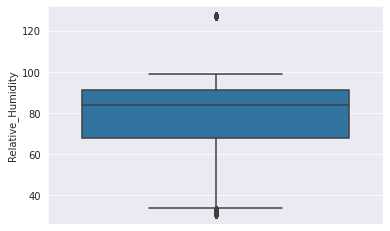

In [110]:
sns.boxplot(y='Relative_Humidity',data=train)

In [111]:
finding_outliers(train,'Sensor2_PM2.5').sort_values('Sensor2_PM2.5')

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,difference_sensor
70714,ID_LIGONRLEX0I3,2021-12-05 08:07:06,77.08000,88.92000,19.70000,97.00000,0,-11.84000
167459,ID_G2TUZ7UECAJU,2022-01-12 06:34:16,109.43000,88.92000,19.20000,96.00000,0,20.51000
105180,ID_XSNIAIXBOMBX,2021-11-07 00:55:12,92.20000,88.92000,20.40000,93.00000,0,3.28000
5587,ID_9K19OSAIARCL,2021-12-24 22:56:10,69.93000,88.92000,22.30000,87.00000,0,-18.99000
225336,ID_T2TQDMXSG7VC,2021-12-19 19:56:51,71.43000,88.92000,20.90000,91.00000,0,-17.49000
...,...,...,...,...,...,...,...,...
84700,ID_B98T6ZM6S8R7,2021-10-24 12:47:30,937.76000,937.06000,31.70000,49.00000,0,0.70000
134321,ID_O2DCEJBPJF62,2021-10-24 10:26:25,946.34000,945.64000,29.50000,57.00000,0,0.70000
192150,ID_GCMDDWG5JANF,2021-10-24 16:58:37,954.78000,954.08000,31.20000,55.00000,0,0.70000
24285,ID_19A5W0O3JB75,2021-10-24 10:20:20,962.35000,961.65000,29.50000,57.00000,0,0.70000


In [112]:
iqr_fare=train['Sensor2_PM2.5'].quantile(0.75)-train['Sensor2_PM2.5'].quantile(0.25)
train['Sensor2_PM2.5'].quantile(0.75)+1.5*iqr_fare

88.9

In [113]:
train.loc[(finding_outliers(train,'Sensor2_PM2.5').index,'Sensor2_PM2.5')]=train['Sensor2_PM2.5'].quantile(0.75)+1.5*iqr_fare

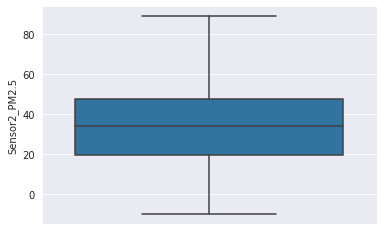

In [114]:
sns.boxplot(y='Sensor2_PM2.5',data=train)

In [115]:
finding_outliers(train,'Sensor1_PM2.5').sort_values('Sensor1_PM2.5')

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,difference_sensor
286953,ID_IN8RHTX2SB6U,2021-10-28 01:33:01,89.08000,85.28000,20.40000,91.00000,0,3.80000
220961,ID_MQZUWMIMD5LY,2021-12-20 06:28:51,89.08000,88.90000,20.20000,96.00000,0,-25.85000
52501,ID_S02HNYC4EC2J,2022-01-16 04:35:28,89.08000,88.90000,18.00000,95.00000,0,-23.30000
116651,ID_P5HX6FSN6216,2022-01-16 05:15:39,89.08000,77.07000,17.90000,96.00000,0,12.01000
166229,ID_VRKJJBRO07Y2,2021-11-11 07:58:27,89.08000,88.90000,20.00000,96.00000,0,-0.10000
...,...,...,...,...,...,...,...,...
84700,ID_B98T6ZM6S8R7,2021-10-24 12:47:30,937.76000,88.90000,31.70000,49.00000,0,0.70000
134321,ID_O2DCEJBPJF62,2021-10-24 10:26:25,946.34000,88.90000,29.50000,57.00000,0,0.70000
192150,ID_GCMDDWG5JANF,2021-10-24 16:58:37,954.78000,88.90000,31.20000,55.00000,0,0.70000
24285,ID_19A5W0O3JB75,2021-10-24 10:20:20,962.35000,88.90000,29.50000,57.00000,0,0.70000


In [116]:
iqr_fare=train['Sensor1_PM2.5'].quantile(0.75)-train['Sensor1_PM2.5'].quantile(0.25)
train['Sensor1_PM2.5'].quantile(0.75)+1.5*iqr_fare

89.075

In [117]:
train.loc[(finding_outliers(train,'Sensor1_PM2.5').index,'Sensor1_PM2.5')]=train['Sensor1_PM2.5'].quantile(0.75)+1.5*iqr_fare

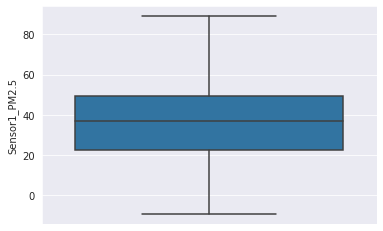

In [118]:
sns.boxplot(y='Sensor1_PM2.5',data=train)

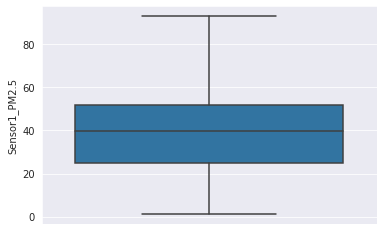

In [119]:
finding_outliers(test,'Sensor1_PM2.5').sort_values('Sensor1_PM2.5')
iqr_fare=test['Sensor1_PM2.5'].quantile(0.75)-test['Sensor1_PM2.5'].quantile(0.25)
test['Sensor1_PM2.5'].quantile(0.75)+1.5*iqr_fare
test.loc[(finding_outliers(test,'Sensor1_PM2.5').index,'Sensor1_PM2.5')]=test['Sensor1_PM2.5'].quantile(0.75)+1.5*iqr_fare
sns.boxplot(y='Sensor1_PM2.5',data=test)

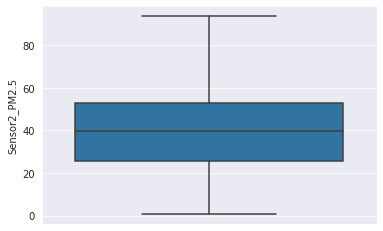

In [120]:
finding_outliers(test,'Sensor2_PM2.5').sort_values('Sensor2_PM2.5')
iqr_fare=test['Sensor2_PM2.5'].quantile(0.75)-test['Sensor2_PM2.5'].quantile(0.25)
test['Sensor2_PM2.5'].quantile(0.75)+1.5*iqr_fare
test.loc[(finding_outliers(test,'Sensor2_PM2.5').index,'Sensor2_PM2.5')]=test['Sensor2_PM2.5'].quantile(0.75)+1.5*iqr_fare
sns.boxplot(y='Sensor2_PM2.5',data=test)

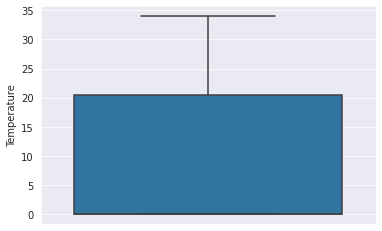

In [121]:
finding_outliers(test,'Temperature').sort_values('Temperature')
iqr_fare=test['Temperature'].quantile(0.75)-test['Temperature'].quantile(0.25)
test['Temperature'].quantile(0.75)+1.5*iqr_fare
test.loc[(finding_outliers(test,'Temperature').index,'Temperature')]=test['Temperature'].quantile(0.75)+1.5*iqr_fare
sns.boxplot(y='Temperature',data=test)

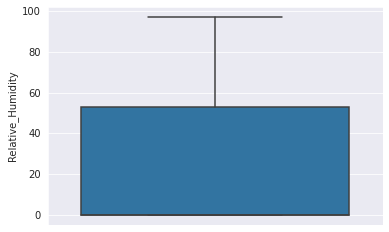

In [122]:
finding_outliers(test,'Relative_Humidity').sort_values('Relative_Humidity')
iqr_fare=test['Relative_Humidity'].quantile(0.75)-test[	'Relative_Humidity'].quantile(0.25)
test['Relative_Humidity'].quantile(0.75)+1.5*iqr_fare
test.loc[(finding_outliers(test,'Relative_Humidity').index,'Relative_Humidity')]=test['Relative_Humidity'].quantile(0.75)+1.5*iqr_fare
sns.boxplot(y='Relative_Humidity',data=test)

In [123]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((297177, 8), (127361, 7), (127361, 2))

<a name="Statistics"></a>
## 3. Statistical summaries

In [124]:
# # Train statistical summary
# train.describe(include = 'all')

In [125]:
test.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,difference_sensor
count,127361.00000,127361.00000,127361.00000,127361.00000,127361.00000
mean,41.30736,42.32705,7.30277,22.26732,-1.16307
std,22.57235,22.65826,11.13139,34.82821,11.80517
min,1.23000,0.78000,0.00000,0.00000,-128.56000
25%,24.67000,25.58000,0.00000,0.00000,-7.44000
50%,39.77000,39.88000,0.00000,0.00000,1.92000
75%,52.03000,52.83000,20.50000,53.00000,5.90000
max,93.07000,93.70500,34.00000,97.00000,150.00000


In [126]:
train.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,difference_sensor
count,297177.00000,297177.00000,297177.00000,297177.00000,297177.00000,297177.00000
mean,39.09688,36.55798,23.45489,79.40605,0.37107,2.53694
std,21.72849,21.68320,4.01619,15.57303,0.48309,8.11673
min,-9.45000,-9.70000,16.70000,31.00000,0.00000,-166.54000
25%,22.65000,19.70000,20.40000,68.00000,0.00000,-0.65000
50%,36.77000,34.02000,22.00000,84.00000,0.00000,2.90000
75%,49.22000,47.38000,26.60000,91.00000,1.00000,6.95000
max,89.07500,88.90000,34.90000,127.00000,1.00000,276.48000


From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from *2021-10-15 16:00:34* to *2022-01-21 07:34:57*
 - There is a high correlation between Sensor1_PM2.5	and Sensor2_PM2.5
 - Minimum recorded temperature is *16.70000* and a maximum *34.90000*

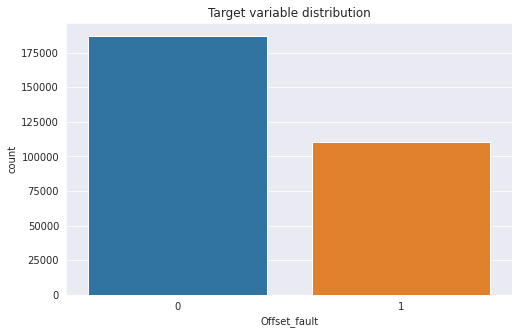

In [127]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["Offset_fault"])
plt.title('Target variable distribution')
plt.show()

The target variable is not well balanced.
Some of the techniques to handle imbalanceness include:
- Smote
- Oversampling
- Undersampling ...

<a name="Missing"></a>
## 4. Missing values and duplicates

In [128]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(False, False)

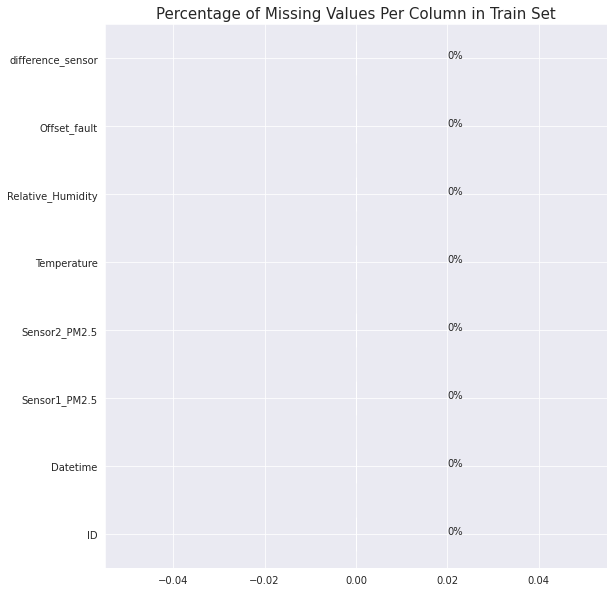

In [129]:
# Plot missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

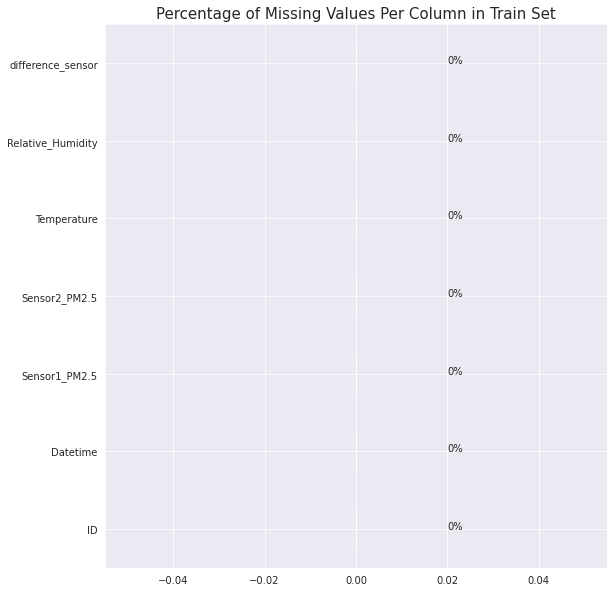

In [130]:
# Plot missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [131]:
# Fill missing values with zeros
# train = train.fillna(0)

In [132]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

No duplictes 

<a name="Outliers"></a>
## 5. Outliers

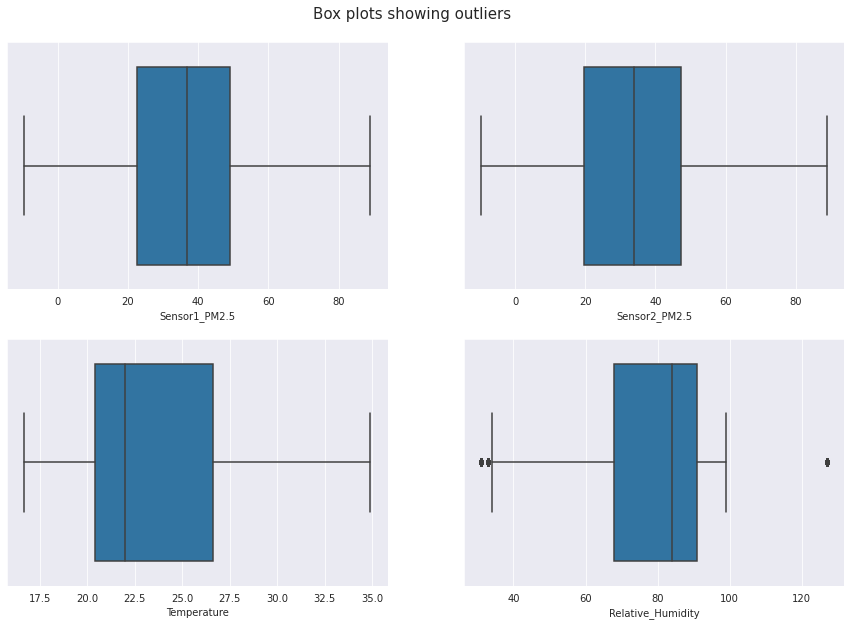

In [133]:
# Plotting boxplots for each of the numerical columns
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train, ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity']):
  sns.boxplot(train[name], ax = ax)

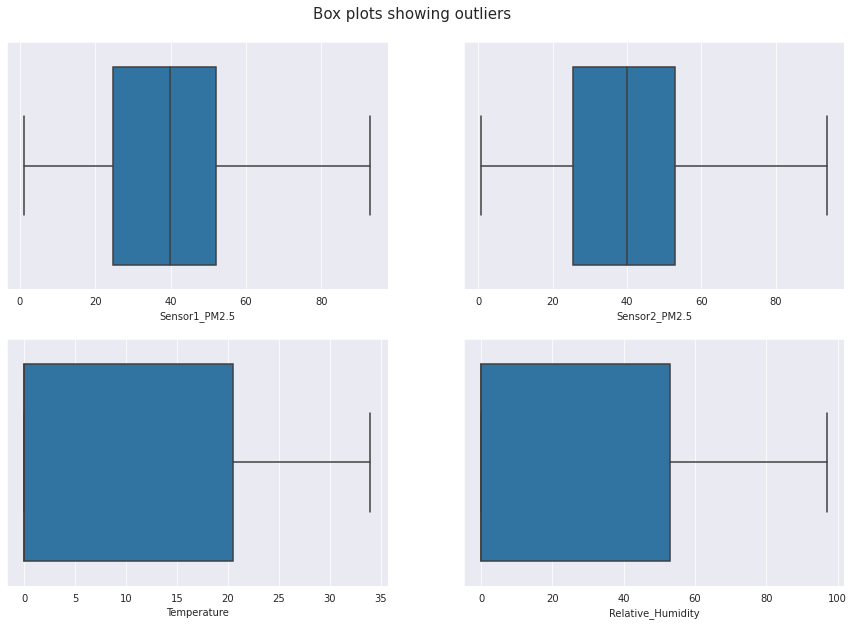

In [134]:
# Plotting boxplots for each of the numerical columns
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), test, ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity']):
  sns.boxplot(test[name], ax = ax)

Outliers are those data points which differs significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...


<a name="Engineering"></a>
## 6. Feature engineering

In [135]:
# Extract day, month year and hour from the Datetime column
# day
train['Datetime_day'] = train.Datetime.dt.day

# month
train['Datetime_month'] = train.Datetime.dt.month
 
# year
train['Datetime_year'] = train.Datetime.dt.year

# hour
train['Datetime_hour'] = train.Datetime.dt.hour

# Preview engineered date features
train[['Datetime', 'Datetime_day', 'Datetime_month', 'Datetime_year', 'Datetime_hour']].head()

,Datetime,Datetime_day,Datetime_month,Datetime_year,Datetime_hour
0,2021-11-03 04:06:31,3,11,2021,4
1,2021-11-08 18:43:23,8,11,2021,18
2,2021-11-07 09:50:33,7,11,2021,9
3,2022-01-01 18:55:15,1,1,2022,18
4,2021-11-05 22:23:48,5,11,2021,22


<a name="Dates"></a>
## 7. Date features EDA

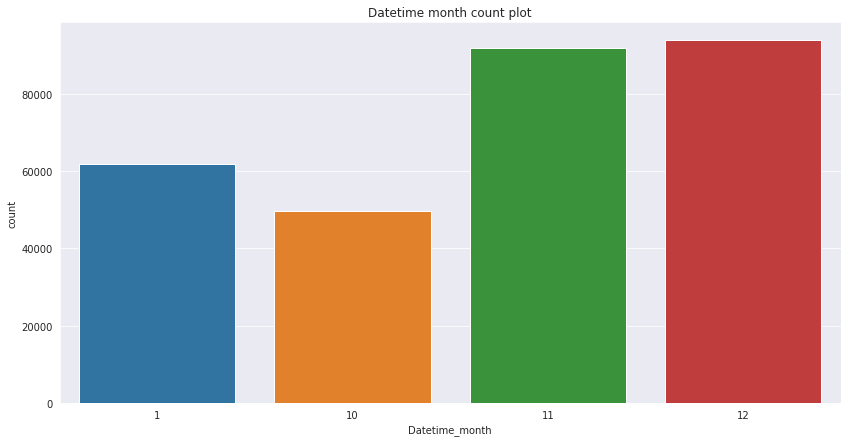

In [136]:
# Datetime month countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'Datetime_month', data = train)
plt.title('Datetime month count plot')
plt.show()

- The only months available in the train set include *Jan, Oct, Nov and Dec*
- March has the least number of observations in the dataset while December has the highest number of observations

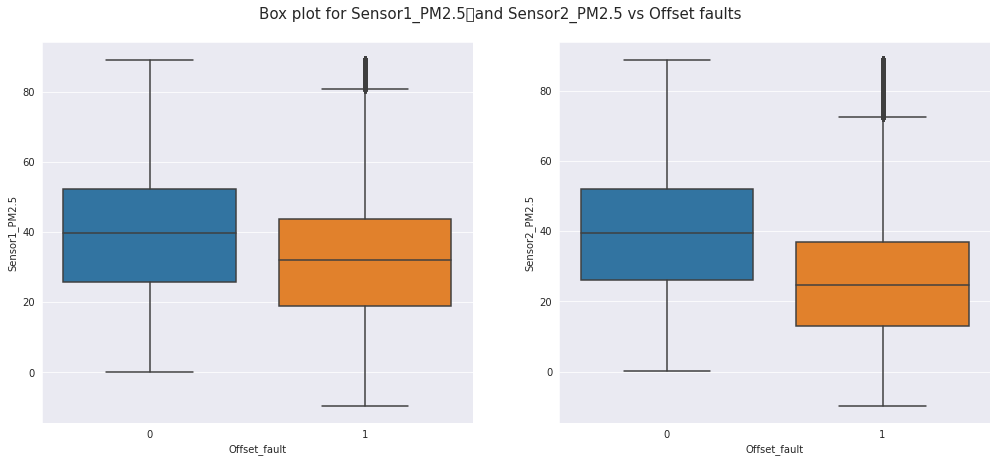

In [137]:
# Box plots for Sensor1_PM2.5	and Sensor2_PM2.5 vs Offset faults
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 7))
fig.suptitle('Box plot for Sensor1_PM2.5	and Sensor2_PM2.5 vs Offset faults', y= 0.95, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train, ['Sensor1_PM2.5', 'Sensor2_PM2.5']):
  sns.boxplot(train.Offset_fault, train[name], ax= ax)

 - Sensor 1 and sensor 2 are highly correlated with majority of the non faulty observations having the highest number of outliers

<a name="Correlations"></a>
## 8. Correlations - EDA

<Figure size 1440x864 with 0 Axes>

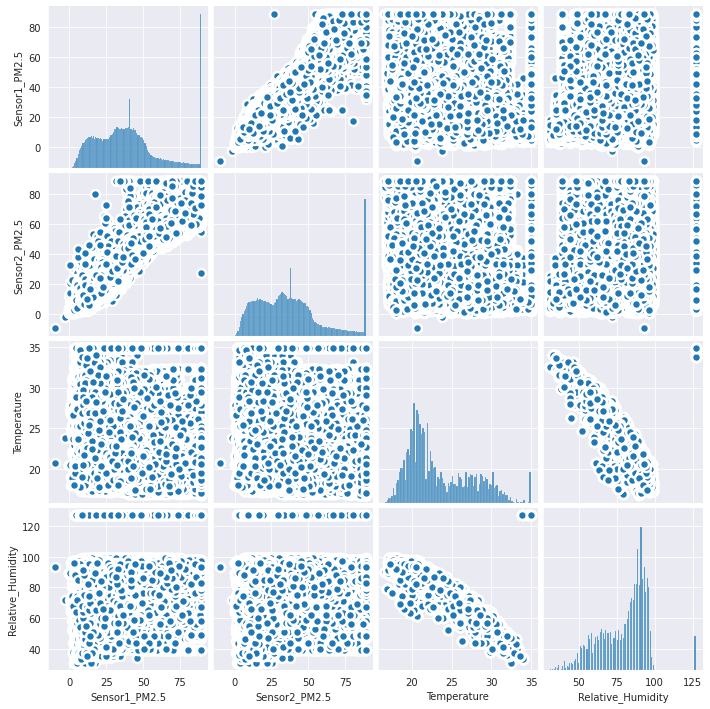

In [138]:
# Type of correlations 
plt.figure(figsize = (20, 12))
num_cols = ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity']
sns.pairplot(train[num_cols], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

<Figure size 1440x864 with 0 Axes>

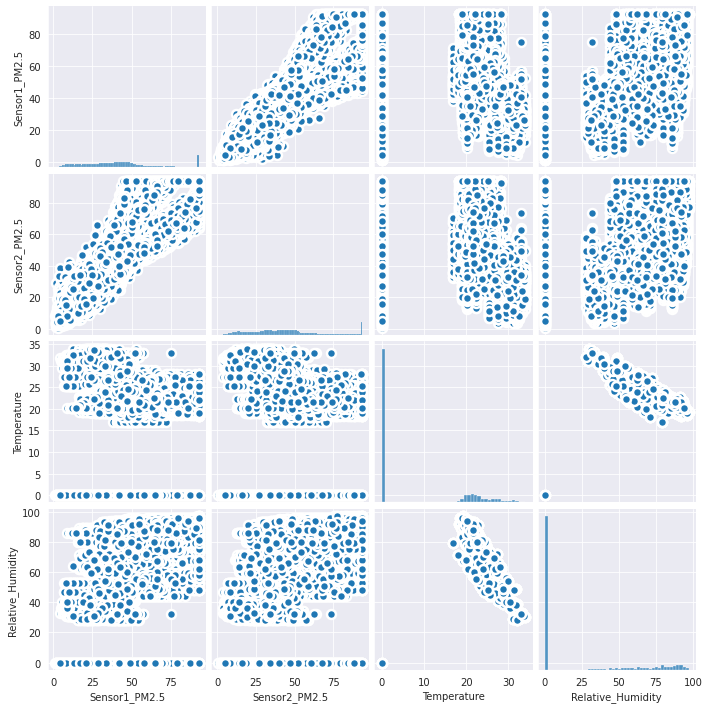

In [139]:
# Type of correlations 
plt.figure(figsize = (20, 12))
num_cols = ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity']
sns.pairplot(test[num_cols], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

 - There is a positive correlation between Sensor1_PM2.5	Sensor2_PM2.5
 - There is a negative correlation between temperature and humidity
 - There seems to be no correlation between sensor PM2.5 and temperature/humidity

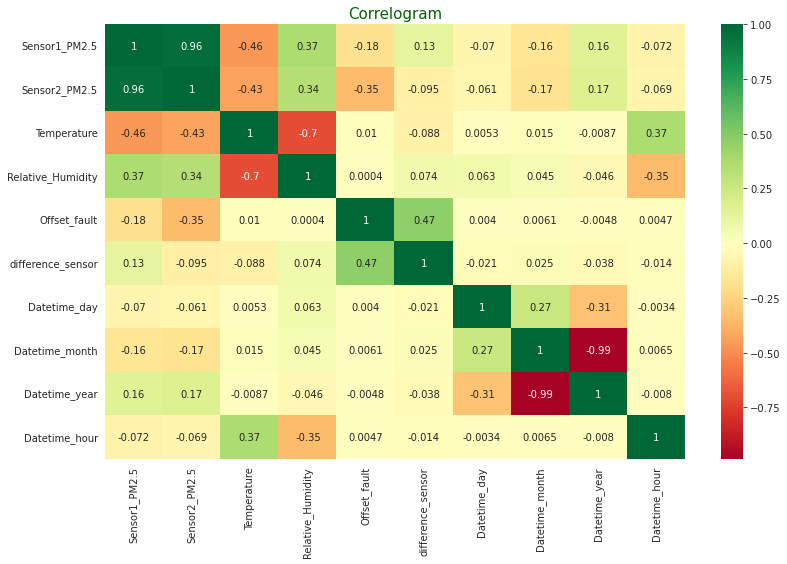

In [140]:
# Quantify correlations
corr = train.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

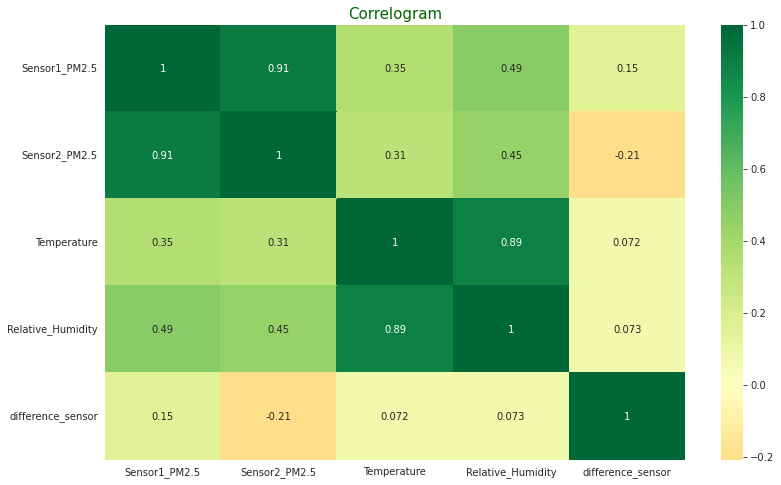

In [141]:
# Quantify correlations
corr = test.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

- There is a 0.96 positive correlation between sensor1 PM2.5 and sensor2 PM2.5
- There is a -0.99 negative correlation between temperature and humidity

<a name="Preprocess"></a>
## 9.  Preprocess test dataset

In [142]:
# Extract day, month and year from the Datetime column
test['Datetime_day'] = test.Datetime.dt.day
test['Datetime_month'] = test.Datetime.dt.month
test['Datetime_year'] = test.Datetime.dt.year
test['Datetime_hour'] = test.Datetime.dt.hour

# Fill in missing values with Zeroes
# test = test.fillna(test.mean())

# Preview engineered test set
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,difference_sensor,Datetime_day,Datetime_month,Datetime_year,Datetime_hour
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75000,93.70500,22.20000,56.00000,-24.03000,28,1,2022,8
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03000,52.18000,0.00000,0.00000,3.85000,16,2,2022,21
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,93.07000,93.70500,28.10000,63.00000,40.62000,24,1,2022,17
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17000,83.85000,21.60000,82.00000,-20.68000,31,1,2022,7
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23000,53.07000,22.70000,80.00000,16.16000,31,1,2022,0


<a name="Modelling"></a>
## 10.  Modelling

In [143]:
# Selecting the independent variables and the target variable
train_feats = ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity',	'Datetime_day',\
               'Datetime_month', 'Datetime_hour','difference_sensor']

X = train[train_feats]#.fillna(train.mean())
y = train.Offset_fault

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Instantiating the model
# clf = RandomForestClassifier(max_depth = 3, random_state = 0)
# clf.fit(X_train, y_train)

# # Making predictions
# y_pred = clf.predict(X_test)

# # Measuring the accuracy of the model
# print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
# print('\n')
# print(f'{classification_report(y_test, y_pred)}')

In [144]:
# from sklearn.preprocessing import StandardScaler    
# st_x= StandardScaler()  
# X_train= st_x.fit_transform(X_train)    
# X_test= st_x.transform(X_test)

In [145]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier
# oversample = SMOTE()
# X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.001,
#       max_depth=15, random_state=0).fit(X_train_smote, y_train_smote)

# clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# clf = xgb.XGBClassifier(objective= 'binary:logistic',nthread=18,seed=100, random_state=42)
# clf.fit(X_train_smote, y_train_smote)
# clf = lgb.LGBMClassifier()
# clf.fit(X_train_smote, y_train_smote)
# y_pred = clf.predict(X_test)

# # # # Measuring the accuracy of the model
# print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
# print('\n')
# print(f'{classification_report(y_test, y_pred)}')

In [146]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
# from catboost import CatBoostClassifier
from xgboost import cv
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import AdaBoostClassifier

In [166]:
clf1 = AdaBoostClassifier(n_estimators=200)
clf2 = XGBClassifier(random_state=222,max_depth=15,learning_rate =0.001,n_estimators=200)
clf3 = lgb.LGBMClassifier(learning_rate=0.0001,max_depth=-15,random_state=42,n_estimators=200)
clf4 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.001, max_features=2, max_depth=5, random_state=0)
clf = VotingClassifier(estimators=[('ada', clf1),('xgb', clf2), ('lgb', clf3),('grad',clf4)],voting='hard')


clf.fit(X_train_smote, y_train_smote)
# eval_set = [(X_test, y_test)]
# clf.fit(X_train_smote, y_train_smote, early_stopping_rounds=10, eval_metric="error", eval_set=eval_set, verbose=True)

# Making predictions
y_pred = clf.predict(X_test)

predictions = [round(value) for value in y_pred]
# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, predictions)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

Accuracy score: 0.9317921798236759


              precision    recall  f1-score   support

           0       0.95      0.94      0.95     37272
           1       0.91      0.91      0.91     22164

    accuracy                           0.93     59436
   macro avg       0.93      0.93      0.93     59436
weighted avg       0.93      0.93      0.93     59436



In [ ]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.model_selection import GridSearchCV
# seed=111
# bc= BaggingClassifier(random_state=seed)

# bc_hyp={'n_estimators':[5,10,20,50,100,200]}

# bc_cv=GridSearchCV(bc,bc_hyp,cv=5)

# bc_cv.fit(X_train,y_train)

# print(bc_cv.best_score_)
# print(bc_cv.best_estimator_)  

In [ ]:
#  # Making predictions
# y_pred = bc_cv.predict(X_test)

# # # # Measuring the accuracy of the model
# print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
# print('\n')
# print(f'{classification_report(y_test, y_pred)}')

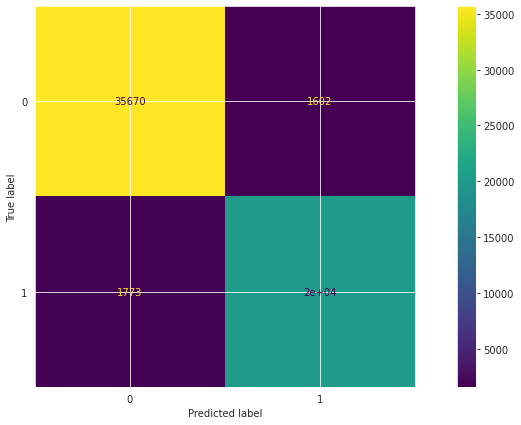

In [164]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

In [165]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

AttributeError: ignored

<a name="Predictions"></a>
## 11. Making predictions of the test set and creating a submission file

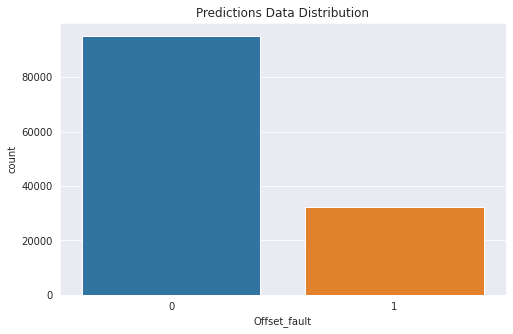

In [167]:
# Make prediction on the test set
test_df = test[train_feats]
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.Offset_fault = predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(sub_file.Offset_fault)
plt.title('Predictions Data Distribution');

 - Majority of the model predictions are 0

In [168]:
# Create file
sub_file.to_csv('Baseline23.csv', index = False)

<a name="Tips"></a>
##12. TO DOs

1. Generate more features, you can work on aggregating the columns( e.g mean temperature , mean humidity  etc)
2. For the datetime you can generate more features, day of the week, week of the year ...
3. Perform more EDA to get a better Understanding of the data, 
4. Try other classifier models
5. Experiment with different startegies of handling the missing values




## ALL THE BEST! 